In [1]:
%load_ext autoreload
%autoreload 2
%run prerun.py
%matplotlib inline

device = torch.device('cuda:3')

SOLVERS:  ['dopri5', 'bdf', 'rk4', 'midpoint', 'adams', 'explicit_adams', 'fixed_adams']
{'tanh': Tanh(), 'relu': ReLU(), 'softplus': Softplus(beta=1, threshold=20), 'elu': ELU(alpha=1.0), 'swish': Swish(), 'square': Lambda(), 'identity': Lambda()}


## Data

In [2]:
sys.path.append('../')
from model import YModel, OptLoss
from utils import generate_data
y_sampler = YModel()
mu_range = (-10, 10)
n_samples = 500
x, conditions = generate_data(y_sampler, device, n_samples=n_samples, mu_range=mu_range, mu_dim=2)

print(x.shape, conditions.shape)

torch.Size([500, 1]) torch.Size([500, 3])


## Define model

In [3]:
regularization_fns = None
# regularization_fns, regularization_coeffs = create_regularization_fns()

model = build_model_tabular(dims=1, 
                            condition_dim=3,
                            layer_type='concat_v2',
                            num_blocks=3,
                            rademacher=False,
                            nonlinearity='tanh',
                            solver='dopri5',
                            hidden_dims=(128, 128),
                            bn_lag=0.01, 
                            batch_norm=True,
                            regularization_fns=regularization_fns).to(device)
sum(p.numel() for p in model.parameters()  if p.requires_grad)

78068

In [4]:
import torch.utils.data as pytorch_data_utils
BATCH_SIZE = 1024
dataset = torch.utils.data.TensorDataset(x, conditions)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Training

iter 204: loss = 2.077 0.001


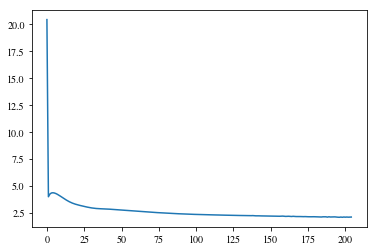

KeyboardInterrupt: 

In [5]:
from tqdm import tqdm_notebook as tqdm

trainable_parametrs = list(model.parameters()) 
optimizer = torch.optim.Adam(trainable_parametrs, lr=1e-3)
losses = []
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100)

B = 5000
for epoch in tqdm(range(1000)):
    for x_batch, cond_batch in tqdm(dataloader):
        x_batch = x_batch.to(device)
        cond_batch = cond_batch.to(device)

        loss = compute_loss(model, data=x_batch, condition=cond_batch)

        if loss != loss:
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        scheduler.step(loss)

    clear_output()
    print('iter %s:' % epoch, 'loss = %.3f' % loss, optimizer.param_groups[0]['lr'])
    plt.figure()
    plt.plot(losses)
    # plt.ylim(1.1, 3)
    plt.show()

## Evalutation

In [597]:
model.eval();
model.cpu();
sample_fn, density_fn = get_transforms(model)

AttributeError: 'function' object has no attribute 'eval'

In [599]:
mu_range_test = (-10, 10)
batch_size = 100
mu_samples = 5000

In [600]:
mu = dist.Uniform(*mu_range_test).sample([mu_samples, 2]) # .to(device)
mu.requires_grad=True
mu_r = mu.repeat(1, batch_size).view(-1, 2)
x_r = y_sampler.x_dist.sample(torch.Size([len(mu) * batch_size , 1])) # .to(device)

In [601]:
samples = sample_fn(torch.randn(mu_samples * batch_size, 1).float(), torch.cat([mu_r, x_r],dim=1))
rs = OptLoss.SigmoidLoss(samples, 5, 10).reshape(-1, batch_size).mean(dim=1)

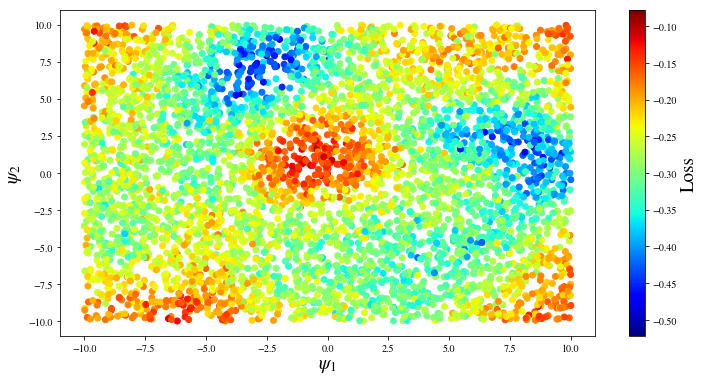

In [602]:
plt.figure(figsize=(12, 6))

plt.scatter(mu[:, 0].cpu().detach().numpy(), mu[:,1].cpu().detach().numpy(), c=rs.cpu().detach().numpy(),  cmap=my_cmap)
cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)

In [603]:
y_sampler.make_condition_sample({'mu': mu_r, 'X': x_r})

y = y_sampler.condition_sample()

In [604]:
log_density = density_fn(y, torch.cat([mu_r, x_r],dim=1))

In [608]:
log_density_mean = log_density.reshape(-1, batch_size).mean(dim=1)

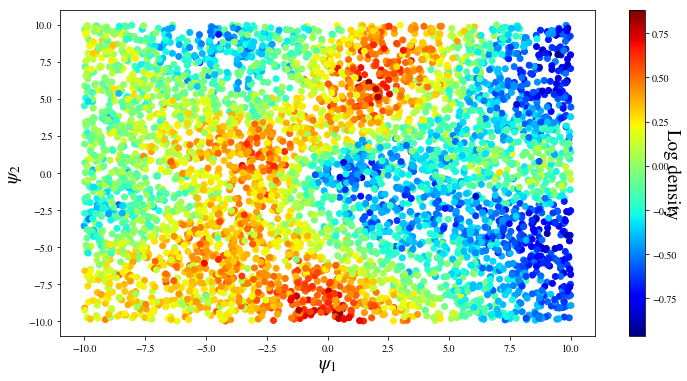

In [610]:
plt.figure(figsize=(12, 6))
plt.scatter(mu[:,0].cpu().detach().numpy(), mu[:, 1].cpu().detach().numpy(), 
            c=log_density_mean.detach().cpu().numpy(), cmap=my_cmap)
cbar = plt.colorbar()

plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Log density', rotation=-90, fontsize=19)
plt.show()

In [612]:
log_density_std = log_density.reshape(-1, batch_size).std(dim=1)

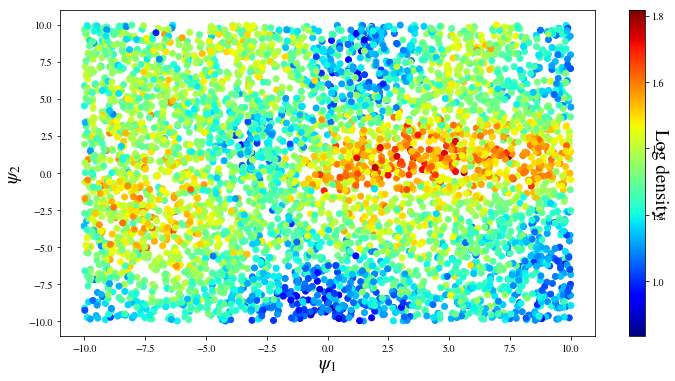

In [613]:
plt.figure(figsize=(12, 6))
plt.scatter(mu[:,0].cpu().detach().numpy(), mu[:, 1].cpu().detach().numpy(), 
            c=log_density_std.detach().cpu().numpy(), cmap=my_cmap)
cbar = plt.colorbar()

plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Log density ', rotation=-90, fontsize=19)
plt.show()

## Multifidelity part

In [69]:
import GPy
import emukit.multi_fidelity
import emukit.test_functions
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel

In [70]:
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

In [71]:
X_train, Y_train = convert_xy_lists_to_arrays([mu.detach().cpu().numpy(), conditions.detach().cpu().numpy()[:, :2]], 
                                              [rs.view(-1,1).detach().cpu().numpy(), x.detach().cpu().numpy()])


In [72]:
from emukit.multi_fidelity.models.non_linear_multi_fidelity_model import make_non_linear_kernels, NonLinearMultiFidelityModel

In [78]:
base_kernel = GPy.kern.RBF
kernels = make_non_linear_kernels(base_kernel, 2, X_train.shape[1] - 1)
nonlin_mf_model = NonLinearMultiFidelityModel(X_train, 
                                              Y_train, 
                                              n_fidelities=2, 
                                              kernels=kernels, 
                                              verbose=True, optimization_restarts=5)

In [ ]:
for m in nonlin_mf_model.models[1:]:
    m.Gaussian_noise.variance.fix(0.05)
    
nonlin_mf_model.optimize()

Warning - optimization restart 1/5 failed
Warning - optimization restart 2/5 failed
Warning - optimization restart 3/5 failed
Warning - optimization restart 5/5 failed


In [85]:
X_test = np.concatenate([mu.detach().cpu().numpy(), np.ones((len(mu), 1))], axis=1)

In [86]:
hf_mean_nonlin_mf_model, hf_var_nonlin_mf_model = nonlin_mf_model.predict(X_test)

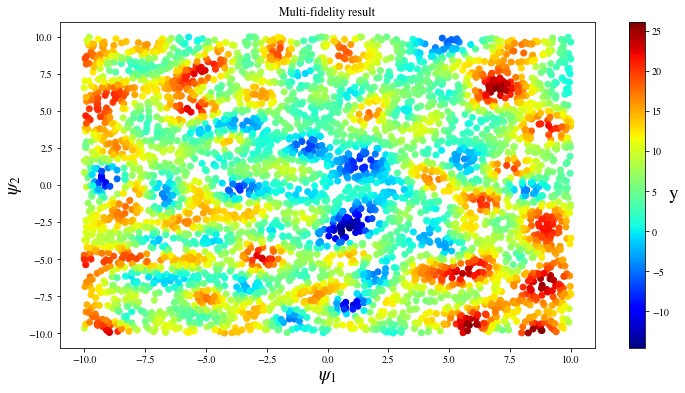

In [88]:
plt.figure(figsize=(12, 6))
plt.scatter(mu[:, 0].cpu().detach().numpy(), 
            mu[:, 1].cpu().detach().numpy(), 
            c=hf_mean_nonlin_mf_model.reshape(-1), cmap=my_cmap)
cbar = plt.colorbar()

plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('y', rotation=360, fontsize=19)
plt.title('Multi-fidelity result')
plt.show()

In [496]:
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.infer as infer
import pyro.infer.mcmc as mcmc
from pyro.contrib import autoname
from pyro.contrib.examples.util import get_data_loader

In [511]:
N1 = 100
X1 = torch.randn(N1, 2)
y1 = np.sin(X1).sum(dim=1)

N2 = 20
X2 = torch.randn(N2, 2)
y2 = np.cos(X2).sum(dim=1)

In [581]:
class DeepGP(gp.parameterized.Parameterized):
    def __init__(self, X1, y1, X2, y2):
        super(DeepGP, self).__init__()
        self.layer1 = gp.models.VariationalGP(
            X1,
            y1,
            gp.kernels.RBF(2, variance=torch.tensor(1.), lengthscale=torch.tensor(2.)),
            likelihood=gp.likelihoods.Gaussian(torch.tensor(2.)))
        
        self.layer2 = gp.models.VariationalGP(
            X2,
            y2,
            gp.kernels.RBF(3, variance=torch.tensor(1.), lengthscale=torch.tensor(2.)),
            likelihood=gp.likelihoods.Gaussian(torch.tensor(2.))
        )

    @autoname.name_count
    def model(self, X1, X2, y1, y2):
        # X1, X2 = Xs
        # y1, y2 = ys
        self.layer1.set_data(X1, y1)
        h_loc, h_var = self.layer1(X2)
        self.layer1.model()
        h = dist.Normal(h_loc, h_var.sqrt())().view(-1, 1)
        X2_cat = torch.cat([X2, h], dim=1)
        self.layer2.set_data(X2_cat, y2)
        self.layer2.model()

    @autoname.name_count
    def guide(self, X1, X2, y1, y2):
        self.layer1.guide()
        self.layer2.guide()

    # make prediction
    def forward(self, X1, X2, y1, y2):
        # because prediction is stochastic (due to Monte Carlo sample of hidden layer),
        # we make 100 prediction and take the most common one (as in [4])
        pred = []
        for _ in range(100):
            h_loc, h_var = self.layer1(X_new)
            h = dist.Normal(h_loc, h_var.sqrt())()
            f_loc, f_var = self.layer2(h.t())
            pred.append(f_loc.argmax(dim=0))
        return torch.stack(pred).mode(dim=0)[0]

In [582]:
deepgp = DeepGP(X1, y1, torch.cat([X2, torch.randn(len(X2)).view(-1, 1)], dim=1), y2)
from torch.distributions.transforms import AbsTransform, AffineTransform

deepgp.layer1.kernel.set_prior("variance", dist.Uniform(torch.tensor(0.5), torch.tensor(1.5)))
deepgp.layer1.kernel.set_prior("lengthscale", 
                               dist.TransformedDistribution(
                                   dist.Gamma(torch.tensor(7.5), torch.tensor(1.)),
                                   [AffineTransform(loc=1, scale=1)])
                              )

deepgp.layer2.kernel.set_prior("variance", dist.Uniform(torch.tensor(0.5), torch.tensor(1.5)))
deepgp.layer2.kernel.set_prior("lengthscale", 
                               dist.TransformedDistribution(
                                   dist.Gamma(torch.tensor(7.5), torch.tensor(1.)),
                                   [AffineTransform(loc=1, scale=1)])
                              )

In [590]:
optimizer = torch.optim.Adam(deepgp.parameters(), lr=1e-4)
loss_fn = infer.Trace_ELBO().differentiable_loss

In [591]:
# sites = pyro.poutine.trace(deepgp.model).get_trace(X1, X2, y1, y2).stochastic_nodes

In [592]:
def train(train_loader, gpmodule, optimizer, loss_fn, epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        data = data.reshape(-1, 784)
        optimizer.zero_grad()
        loss = loss_fn(gpmodule.model, gpmodule.guide, data, target)
        loss.backward()
        optimizer.step()
        idx = batch_idx + 1
        if idx % 10 == 0:
            print("Train Epoch: {:2d} [{:5d}/{} ({:2.0f}%)]\tLoss: {:.6f}"
                  .format(epoch, idx * len(data), len(train_loader.dataset),
                          100. * idx / len(train_loader), loss))

def test(test_loader, gpmodule):
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        data = data.reshape(-1, 784)
        pred = gpmodule(data)
        # compare prediction and target to count accuaracy
        correct += pred.eq(target).long().cpu().sum().item()

    print("\nTest set: Accuracy: {}/{} ({:.2f}%)\n".format(
        correct, 
        len(test_loader.dataset), 
        100. * correct / len(test_loader.dataset)))

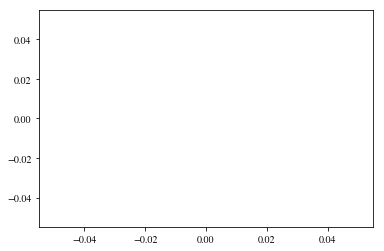

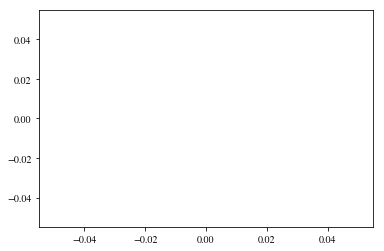

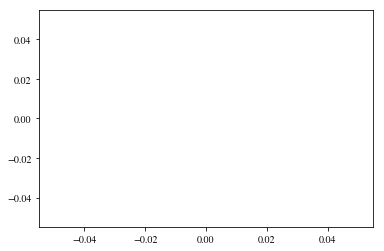

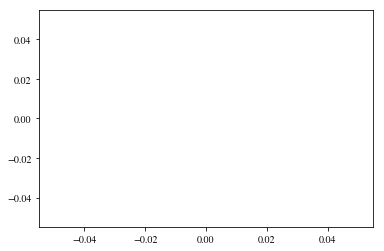

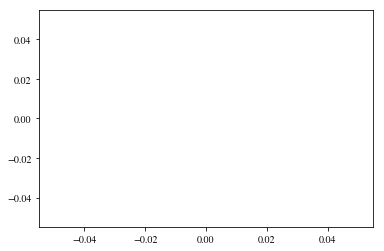

KeyboardInterrupt: 

In [593]:
losses = []

for i in tqdm(range(10000)):
    optimizer.zero_grad()
    loss = loss_fn(deepgp.model, deepgp.guide, X1, X2, y1, y2)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if i % 200 == 0:
        plt.figure()
        plt.plot(losses)
        plt.show()

In [ ]:
plt.plot(losses)

In [594]:
losses

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan